In [ ]:
# Install PyTorch and Torch Geometric dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html


Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv



/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [ ]:
dataset = Planetoid(root='/tmp/Citeseer', name='Citeseer')
data = dataset[0]


Processing...
Done!


In [ ]:
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
def train(model, data, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
    return acc.item()


In [ ]:
gcn_model = GCN(in_channels=dataset.num_node_features, hidden_channels=64, out_channels=dataset.num_classes)
gcn_model = train(gcn_model, data)
print("✅ GCN Test Accuracy:", test(gcn_model, data))


✅ GCN Test Accuracy: 0.6679999828338623


In [ ]:
import os
os.makedirs('/content/drive/MyDrive/gnnfingers/models', exist_ok=True)


In [ ]:
torch.save(gcn_model.state_dict(), '/content/drive/MyDrive/gnnfingers/models/victim_Citeseer_GCN.pth')


In [ ]:
import torch
import torch.nn.functional as F
import os

# Reload base model definition
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Directory to save positive variants
pos_dir = '/content/drive/MyDrive/gnnfingers/variants/Citeseer_GCN_Positive'
os.makedirs(pos_dir, exist_ok=True)

# Load original victim model
victim = GCN(dataset.num_node_features, 64, dataset.num_classes)
victim.load_state_dict(torch.load('/content/drive/MyDrive/gnnfingers/models/victim_Citeseer_GCN.pth'))

# Fine-tune 20 variants with small data perturbations
for i in range(20):
    variant = GCN(dataset.num_node_features, 64, dataset.num_classes)
    variant.load_state_dict(torch.load('/content/drive/MyDrive/gnnfingers/models/victim_Citeseer_GCN.pth'))

    optimizer = torch.optim.Adam(variant.parameters(), lr=0.001)
    variant.train()
    for epoch in range(5):  # small fine-tuning (5 epochs)
        optimizer.zero_grad()
        out = variant(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    torch.save(variant.state_dict(), f"{pos_dir}/positive_{i}.pth")
    print(f"✅ Saved Positive Variant {i+1}/20")


✅ Saved Positive Variant 1/20
✅ Saved Positive Variant 2/20
✅ Saved Positive Variant 3/20
✅ Saved Positive Variant 4/20
✅ Saved Positive Variant 5/20
✅ Saved Positive Variant 6/20
✅ Saved Positive Variant 7/20
✅ Saved Positive Variant 8/20
✅ Saved Positive Variant 9/20
✅ Saved Positive Variant 10/20
✅ Saved Positive Variant 11/20
✅ Saved Positive Variant 12/20
✅ Saved Positive Variant 13/20
✅ Saved Positive Variant 14/20
✅ Saved Positive Variant 15/20
✅ Saved Positive Variant 16/20
✅ Saved Positive Variant 17/20
✅ Saved Positive Variant 18/20
✅ Saved Positive Variant 19/20
✅ Saved Positive Variant 20/20


In [ ]:
import torch
import torch.nn.functional as F
import os
import random

# Directory to save negative variants
neg_dir = '/content/drive/MyDrive/gnnfingers/variants/Citeseer_GCN_Negative'
os.makedirs(neg_dir, exist_ok=True)

# Generate 20 negative GCNs
for i in range(20):
    torch.manual_seed(i + 100)  # different seed
    random.seed(i + 100)

    model = GCN(dataset.num_node_features, 64, dataset.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(20):  # train a bit longer than positive
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    torch.save(model.state_dict(), f"{neg_dir}/negative_{i}.pth")
    print(f"✅ Saved Negative Variant {i+1}/20")


✅ Saved Negative Variant 1/20
✅ Saved Negative Variant 2/20
✅ Saved Negative Variant 3/20
✅ Saved Negative Variant 4/20
✅ Saved Negative Variant 5/20
✅ Saved Negative Variant 6/20
✅ Saved Negative Variant 7/20
✅ Saved Negative Variant 8/20
✅ Saved Negative Variant 9/20
✅ Saved Negative Variant 10/20
✅ Saved Negative Variant 11/20
✅ Saved Negative Variant 12/20
✅ Saved Negative Variant 13/20
✅ Saved Negative Variant 14/20
✅ Saved Negative Variant 15/20
✅ Saved Negative Variant 16/20
✅ Saved Negative Variant 17/20
✅ Saved Negative Variant 18/20
✅ Saved Negative Variant 19/20
✅ Saved Negative Variant 20/20


In [ ]:
import os
os.makedirs('/content/drive/MyDrive/gnnfingers/fingerprint', exist_ok=True)


In [ ]:
torch.save(fingerprint_graph, '/content/drive/MyDrive/gnnfingers/fingerprint/fingerprint_Citeseer.pt')
print(" Fingerprint graph saved.")


 Fingerprint graph saved.


In [ ]:
from torch.serialization import add_safe_globals
from torch_geometric.data import Data
add_safe_globals([Data])


In [ ]:
fingerprint_graph = torch.load('/content/drive/MyDrive/gnnfingers/fingerprint/fingerprint_Citeseer.pt', weights_only=False)
fingerprint_graph.batch = torch.zeros(fingerprint_graph.num_nodes, dtype=torch.long)


In [ ]:
from torch_geometric.nn import global_mean_pool

def extract_output(model, graph):
    model.eval()
    with torch.no_grad():
        out = model(graph.x, graph.edge_index)
        pooled = global_mean_pool(out, graph.batch)
        return pooled.squeeze().cpu()


In [ ]:
X = []
y = []

# Positive (label = 1)
for i in range(20):
    model = GCN(dataset.num_node_features, 64, dataset.num_classes)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/gnnfingers/variants/Citeseer_GCN_Positive/positive_{i}.pth'))
    X.append(extract_output(model, fingerprint_graph))
    y.append(1)

# Negative (label = 0)
for i in range(20):
    model = GCN(dataset.num_node_features, 64, dataset.num_classes)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/gnnfingers/variants/Citeseer_GCN_Negative/negative_{i}.pth'))
    X.append(extract_output(model, fingerprint_graph))
    y.append(0)

X = torch.stack(X)
y = torch.tensor(y)
print(f"Feature Matrix: {X.shape}, Labels: {y.shape}")


Feature Matrix: torch.Size([40, 6]), Labels: torch.Size([40])


In [ ]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

class Univerifier(nn.Module):
    def __init__(self, input_dim):
        super(Univerifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate and train
model = Univerifier(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    model.train()
    logits = model(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X)
    probs = torch.softmax(logits, dim=1)[:, 1]
    preds = (probs > 0.5).int()

acc = accuracy_score(y.numpy(), preds.numpy())
auc = roc_auc_score(y.numpy(), probs.numpy())
cm = confusion_matrix(y.numpy(), preds.numpy())

print(f" Accuracy: {acc:.4f}")
print(f" Robustness (TPR): {cm[1,1] / cm[1].sum():.4f}")
print(f" Uniqueness (TNR): {cm[0,0] / cm[0].sum():.4f}")
print(f" AUROC: {auc:.4f}")
print(" Confusion Matrix:\n", cm)


 Accuracy: 1.0000
 Robustness (TPR): 1.0000
 Uniqueness (TNR): 1.0000
 AUROC: 1.0000
 Confusion Matrix:
 [[20  0]
 [ 0 20]]


In [ ]:
#Section 3.4.2
import torch.nn as nn
import torch

class FingerprintGraph(nn.Module):
    def __init__(self, num_nodes=32, num_features=dataset.num_node_features, edge_prob=0.1):
        super().__init__()
        self.num_nodes = num_nodes
        self.feat = nn.Parameter(torch.rand((num_nodes, num_features)))

        # Soft edge weights initialized near 0 (will be projected)
        self.adj_logits = nn.Parameter(torch.randn(num_nodes, num_nodes) * 0.01)

    def get_edge_index(self):
        # Turn soft adjacency logits into binary adjacency matrix
        with torch.no_grad():
            adj_matrix = torch.sigmoid(self.adj_logits)
            adj_matrix = torch.triu(adj_matrix, diagonal=1)  # upper triangle
            edge_index = (adj_matrix > 0.5).nonzero(as_tuple=False).t()
            edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # undirected
        return edge_index

    def to_pyg_data(self):
        edge_index = self.get_edge_index()
        return Data(x=self.feat, edge_index=edge_index, batch=torch.zeros(self.num_nodes, dtype=torch.long))



In [ ]:

class Univerifier(nn.Module):
    def __init__(self, input_dim):
        super(Univerifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
import torch.nn.functional as F

# Initialize
fp_graph = FingerprintGraph()
verifier = Univerifier(input_dim=dataset.num_classes)  # output dim of GCN = 6 for Citeseer

opt = torch.optim.Adam(list(fp_graph.parameters()) + list(verifier.parameters()), lr=0.01)

# Load all 20 pos and 20 neg models
positive_models = []
negative_models = []

for i in range(20):
    m_pos = GCN(dataset.num_node_features, 64, dataset.num_classes)
    m_pos.load_state_dict(torch.load(f'/content/drive/MyDrive/gnnfingers/variants/Citeseer_GCN_Positive/positive_{i}.pth'))
    m_pos.eval()
    positive_models.append(m_pos)

    m_neg = GCN(dataset.num_node_features, 64, dataset.num_classes)
    m_neg.load_state_dict(torch.load(f'/content/drive/MyDrive/gnnfingers/variants/Citeseer_GCN_Negative/negative_{i}.pth'))
    m_neg.eval()
    negative_models.append(m_neg)

# Training loop
for epoch in range(100):
    opt.zero_grad()

    # Convert graph to PyG format
    pyg_data = fp_graph.to_pyg_data()

    # Get outputs
    outputs = []

    with torch.no_grad():
        outputs.append(victim(pyg_data.x, pyg_data.edge_index).mean(dim=0))
        for m in positive_models:
            outputs.append(m(pyg_data.x, pyg_data.edge_index).mean(dim=0))
        for m in negative_models:
            outputs.append(m(pyg_data.x, pyg_data.edge_index).mean(dim=0))

    # Stack all
    logits_input = torch.stack(outputs)
    labels = torch.tensor([1]*21 + [0]*20)  # 1: victim + pos, 0: neg

    # Train verifier
    logits = verifier(logits_input)
    loss = F.cross_entropy(logits, labels)
    loss.backward()
    opt.step()

    if (epoch+1) % 10 == 0:
        pred = logits.argmax(dim=1)
        acc = (pred == labels).float().mean().item()
        print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Acc: {acc:.4f}")


Epoch 010 | Loss: 0.0820 | Acc: 1.0000
Epoch 020 | Loss: 0.0176 | Acc: 1.0000
Epoch 030 | Loss: 0.0090 | Acc: 1.0000
Epoch 040 | Loss: 0.0079 | Acc: 1.0000
Epoch 050 | Loss: 0.0032 | Acc: 1.0000
Epoch 060 | Loss: 0.0015 | Acc: 1.0000
Epoch 070 | Loss: 0.0011 | Acc: 1.0000
Epoch 080 | Loss: 0.0010 | Acc: 1.0000
Epoch 090 | Loss: 0.0009 | Acc: 1.0000
Epoch 100 | Loss: 0.0008 | Acc: 1.0000


In [ ]:
verifier.eval()
fp_data = fp_graph.to_pyg_data()

scores = []
labels = []

# Victim
with torch.no_grad():
    out = victim(fp_data.x, fp_data.edge_index).mean(dim=0)
    score = torch.softmax(verifier(out.unsqueeze(0)), dim=1)[:,1].item()
    scores.append(score)
    labels.append(1)

# Positives
for m in positive_models:
    with torch.no_grad():
        out = m(fp_data.x, fp_data.edge_index).mean(dim=0)
        score = torch.softmax(verifier(out.unsqueeze(0)), dim=1)[:,1].item()
        scores.append(score)
        labels.append(1)

# Negatives
for m in negative_models:
    with torch.no_grad():
        out = m(fp_data.x, fp_data.edge_index).mean(dim=0)
        score = torch.softmax(verifier(out.unsqueeze(0)), dim=1)[:,1].item()
        scores.append(score)
        labels.append(0)

scores = torch.tensor(scores)
labels = torch.tensor(labels)


In [ ]:
import numpy as np

thresholds = np.linspace(0, 1, 100)
tpr_list = []
tnr_list = []

for thresh in thresholds:
    preds = (scores > thresh).int()
    tp = ((preds == 1) & (labels == 1)).sum().item()
    fn = ((preds == 0) & (labels == 1)).sum().item()
    tn = ((preds == 0) & (labels == 0)).sum().item()
    fp = ((preds == 1) & (labels == 0)).sum().item()

    tpr = tp / (tp + fn + 1e-6)
    tnr = tn / (tn + fp + 1e-6)

    tpr_list.append(tpr)
    tnr_list.append(tnr)


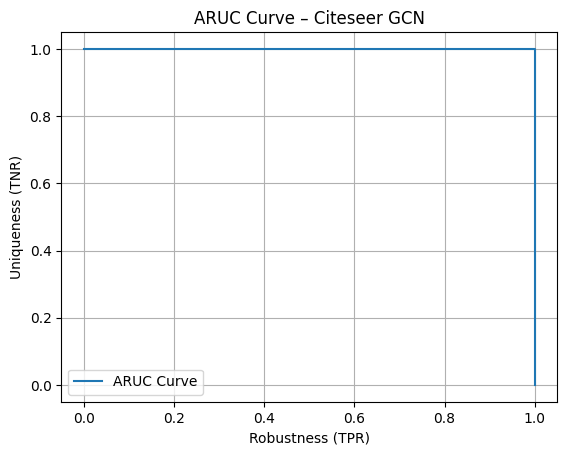

 ARUC Score: 1.0000


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

plt.figure()
plt.plot(tpr_list, tnr_list, label="ARUC Curve")
plt.xlabel("Robustness (TPR)")
plt.ylabel("Uniqueness (TNR)")
plt.title("ARUC Curve – Citeseer GCN")
plt.grid(True)
plt.legend()
plt.show()

aruc_score = auc(tpr_list, tnr_list)
print(f" ARUC Score: {aruc_score:.4f}")


In [ ]:
#Section-4.5
def ablate_fp(fp_graph, mode='A+X'):
    data = fp_graph.to_pyg_data()

    if mode == 'A_only':
        data.x = torch.randn_like(data.x)
    elif mode == 'X_only':
        data.edge_index = torch.empty((2, 0), dtype=torch.long)  # remove all edges

    return data


In [ ]:
def evaluate_ablation(fp_data):
    scores = []
    labels = []

    with torch.no_grad():
        out = victim(fp_data.x, fp_data.edge_index).mean(dim=0)
        score = torch.softmax(verifier(out.unsqueeze(0)), dim=1)[:,1].item()
        scores.append(score)
        labels.append(1)

        for m in positive_models:
            out = m(fp_data.x, fp_data.edge_index).mean(dim=0)
            score = torch.softmax(verifier(out.unsqueeze(0)), dim=1)[:,1].item()
            scores.append(score)
            labels.append(1)

        for m in negative_models:
            out = m(fp_data.x, fp_data.edge_index).mean(dim=0)
            score = torch.softmax(verifier(out.unsqueeze(0)), dim=1)[:,1].item()
            scores.append(score)
            labels.append(0)

    preds = [1 if s > 0.5 else 0 for s in scores]
    labels = torch.tensor(labels)
    preds = torch.tensor(preds)

    acc = (preds == labels).float().mean().item()
    from sklearn.metrics import roc_auc_score, confusion_matrix
    auroc = roc_auc_score(labels, scores)
    cm = confusion_matrix(labels, preds)

    return acc, auroc, cm


In [ ]:
for mode in ['A_only', 'X_only', 'A+X']:
    print(f"\n Evaluating mode: {mode}")
    fp_data = ablate_fp(fp_graph, mode)
    acc, auroc, cm = evaluate_ablation(fp_data)
    print(f"Accuracy: {acc:.4f}, AUROC: {auroc:.4f}")
    print("Confusion Matrix:\n", cm)



 Evaluating mode: A_only
Accuracy: 0.9512, AUROC: 1.0000
Confusion Matrix:
 [[18  2]
 [ 0 21]]

 Evaluating mode: X_only
Accuracy: 1.0000, AUROC: 1.0000
Confusion Matrix:
 [[20  0]
 [ 0 21]]

 Evaluating mode: A+X
Accuracy: 1.0000, AUROC: 1.0000
Confusion Matrix:
 [[20  0]
 [ 0 21]]


In [ ]:
from torch_geometric.nn import global_mean_pool

def extract_logit_output(model, graph):
    with torch.no_grad():
        model.eval()
        out = model(graph.x, graph.edge_index)
        pooled = global_mean_pool(out, graph.batch)
        return pooled.squeeze().cpu()


In [ ]:
X_tsne = []
y_tsne = []

# Victim
X_tsne.append(extract_logit_output(victim, fp_graph.to_pyg_data()))
y_tsne.append(1)

# Positives
for m in positive_models:
    X_tsne.append(extract_logit_output(m, fp_graph.to_pyg_data()))
    y_tsne.append(1)

# Negatives
for m in negative_models:
    X_tsne.append(extract_logit_output(m, fp_graph.to_pyg_data()))
    y_tsne.append(0)

X_tsne = torch.stack(X_tsne).numpy()
y_tsne = np.array(y_tsne)


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_embedded = tsne.fit_transform(X_tsne)


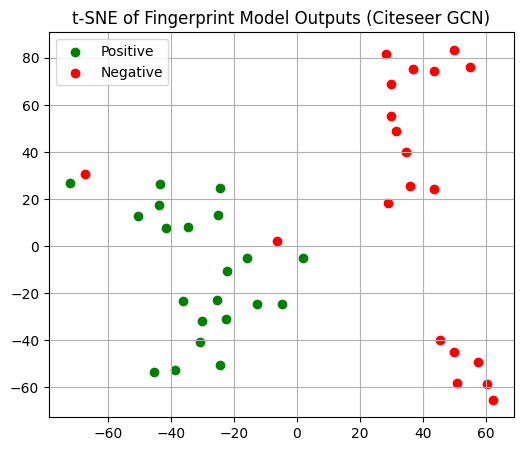

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(X_embedded[y_tsne==1][:,0], X_embedded[y_tsne==1][:,1], label='Positive', c='green')
plt.scatter(X_embedded[y_tsne==0][:,0], X_embedded[y_tsne==0][:,1], label='Negative', c='red')
plt.title("t-SNE of Fingerprint Model Outputs (Citeseer GCN)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGEMean(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
import torch
from torch_geometric.datasets import Planetoid

# Load Citeseer
dataset = Planetoid(root='/tmp/Citeseer', name='Citeseer')
data = dataset[0]

# Initialize model
sage_model = SAGEMean(dataset.num_node_features, 64, dataset.num_classes).to('cpu')
optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
sage_model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = sage_model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")

# Save model
torch.save(sage_model.state_dict(), '/content/drive/MyDrive/gnnfingers/models/victim_Citeseer_SAGEMean.pth')
print(" Saved GraphSAGE victim.")


Epoch 000 | Loss: 1.8024 | Test Acc: 0.1450
Epoch 050 | Loss: 0.0058 | Test Acc: 0.5980
Epoch 100 | Loss: 0.0028 | Test Acc: 0.6740
Epoch 150 | Loss: 0.0026 | Test Acc: 0.6710
Epoch 200 | Loss: 0.0055 | Test Acc: 0.6600
✅ Saved GraphSAGE victim.


In [ ]:
sage_victim = SAGEMean(dataset.num_node_features, 64, dataset.num_classes)
sage_victim.load_state_dict(torch.load("/content/drive/MyDrive/gnnfingers/models/victim_Citeseer_SAGEMean.pth"))
sage_victim.eval()


SAGEMean(
  (conv1): SAGEConv(3703, 64, aggr=mean)
  (conv2): SAGEConv(64, 6, aggr=mean)
)

In [ ]:
def generate_variants(base_model_class, dataset, num_variants=20, mode='positive'):
    variants = []
    for i in range(num_variants):
        model = base_model_class(dataset.num_node_features, 64, dataset.num_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        data = dataset[0].clone()

        if mode == 'negative':
            y = data.y.clone()
            perm = torch.randperm(y.size(0))
            data.y = y[perm]

        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

        model.eval()
        variants.append(model)
    return variants

# Generate and cache
sage_positive_models = generate_variants(SAGEMean, dataset, 20, 'positive')
sage_negative_models = generate_variants(SAGEMean, dataset, 20, 'negative')


In [ ]:
X_cross = []
y_cross = []

# Convert fingerprint graph
fp_data = fp_graph.to_pyg_data()

# Victim (optional)
# X_cross.append(extract_logit_output(sage_victim, fp_data))
# y_cross.append(1)

# Positive SAGE Variants
for m in sage_positive_models:
    X_cross.append(extract_logit_output(m, fp_data))
    y_cross.append(1)

# Negative SAGE Variants
for m in sage_negative_models:
    X_cross.append(extract_logit_output(m, fp_data))
    y_cross.append(0)

X_cross = torch.stack(X_cross)
y_cross = torch.tensor(y_cross)


In [ ]:
verifier.eval()
with torch.no_grad():
    logits = verifier(X_cross)
    probs = torch.softmax(logits, dim=1)[:,1]
    preds = (probs > 0.5).long()


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

acc = accuracy_score(y_cross, preds)
auroc = roc_auc_score(y_cross, probs)
cm = confusion_matrix(y_cross, preds)

print(f"Accuracy: {acc:.4f}")
print(f"AUROC: {auroc:.4f}")
print("Confusion Matrix:\n", cm)


Accuracy: 0.6250
AUROC: 0.6350
Confusion Matrix:
 [[ 9 11]
 [ 4 16]]


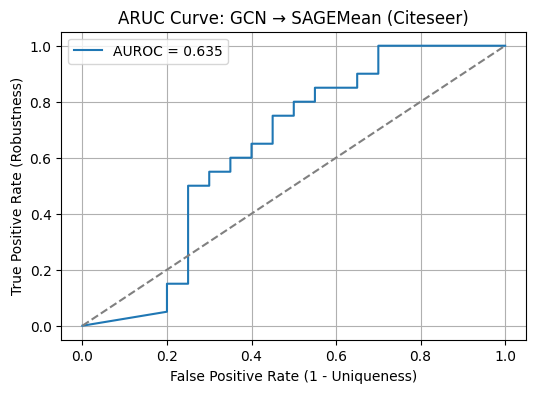

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_cross, probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate (1 - Uniqueness)")
plt.ylabel("True Positive Rate (Robustness)")
plt.title("ARUC Curve: GCN → SAGEMean (Citeseer)")
plt.legend()
plt.grid(True)
plt.show()
